In [ ]:
%%capture
!pip install transformers
!pip install sentence_transformers
!pip install datasets


#df_path='./Items No Flagged 8-16.csv'
df_path='./Items with Facets 8-24-21.xlsx'


prompt_path='./HEXACO 100-Items.csv'
# Set Seeds...
import numpy as np
np.random.seed(2020)
import random
random.seed(2020)

import torch
torch.random.manual_seed(2020) 

In [ ]:
import pandas as pd
df = pd.read_excel(df_path)
df.drop(columns = ["SYNTAX/SEMANTICS", "ENTAILMENT", "CONTEXT", "GEMS"], inplace = True)

df.head()

,Item,Facet_1,Facet_2,Prompt_1,Prompt_2,HEXACO_1,HEXACO_2,Idx_1,Idx_2,is_rev_1,is_rev_2,X1,Factor,Pos.Cosine,Neg.Cosine,STS.Cosine,Distinct.Cosine,Prompt,Internal.Consistency,Cos.Diff,ABS.Cosine.Diff,K_Means,H_Cluster,Internal.STS,Internal.Distinct,Cluster.STS
0,I think I can do something to change the world.,Aesthetic_Appreciation,Unconventionality,"If I had the opportunity, I would like to atte...",I like people who have unconventional views.,"If I had the opportunity, I would like to atte...",I like people who have unconventional views.,49,43,True,True,5990,Openness to Experience,0.309209,0.065427,0.278301,0.014187,"If I had the opportunity, I would like to atte...",0.2318,0.243783,0.243783,0,59,0.257586,0.034579,0.566343
1,I want to be the most powerful person in the w...,Fairness,Greed_Avoidance,"If I knew that I could never get caught, I wou...","I would like to live in a very expensive, high...","If I knew that I could never get caught, I wou...","I would like to live in a very expensive, high...",12,42,True,False,787,Honesty_Humility,0.254595,0.332587,0.332587,0.076583,"If I knew that I could never get caught, I wou...",0.2480,-0.077992,0.077992,0,67,0.301088,0.057102,0.605998
2,I have a strong desire to make a difference in...,Liveliness,Sociability,"On most days, I feel cheerful and optimistic.",I prefer jobs that involve active social inter...,"On most days, I feel cheerful and optimistic.",I prefer jobs that involve active social inter...,46,64,False,True,3373,Extraversion,0.351466,0.313181,0.331320,0.046791,"On most days, I feel cheerful and optimistic. ...",0.2998,0.038285,0.038285,0,67,0.307833,0.049429,0.521685
3,I want to make a difference in the world.,Organization,Diligence,I clean my office or home quite frequently.,"When working, I often set ambitious goals for ...",I clean my office or home quite frequently.,"When working, I often set ambitious goals for ...",2,8,False,False,5006,Conscientiousness,0.223055,0.287482,0.287482,-0.028854,I clean my office or home quite frequently. Wh...,0.2355,-0.064427,0.064427,0,67,0.313847,0.024625,0.563819
4,I know I'm right about the things that I want ...,Flexibility,Patience,I find it hard to compromise with people when ...,Most people tend to get angry more quickly tha...,I find it hard to compromise with people when ...,Most people tend to get angry more quickly tha...,87,69,True,True,3955,Agreeableness,0.076181,0.191245,0.147367,0.032026,I find it hard to compromise with people when ...,0.3330,-0.115063,0.115063,1,89,0.222676,0.079176,0.211560


In [ ]:
def convergent(seqs, curr_key, item_list, sentence_transformer):
    emb_items = torch.tensor(sentence_transformer.encode(item_list))
    #emb_items_pos = sentence_transformer.encode(item_dict[curr_key]['+'])
    #emb_items_neg = sentence_transformer.encode(item_dict[curr_key]['-'])
    #emb_items = (torch.abs(torch.tensor(emb_items_pos)) + torch.abs(torch.tensor(emb_items_neg)))/2


    emb_seqs = sentence_transformer.encode(seqs)
    cos_sim = util.pytorch_cos_sim(emb_seqs, emb_items)
    
    tgt_cosines = torch.median(cos_sim,1).values
    
    
    return tgt_cosines


def discriminant(seqs, curr_key, item_list, sentence_transformer, data, iter_var, item_var = "Item"):

    emb_items = torch.tensor(sentence_transformer.encode(item_list))
    #emb_items_pos = sentence_transformer.encode(item_dict[curr_key]['+'])
    #emb_items_neg = sentence_transformer.encode(item_dict[curr_key]['-'])
    #emb_items = (torch.abs(torch.tensor(emb_items_pos)) + torch.abs(torch.tensor(emb_items_neg)))/2


    emb_seqs = sentence_transformer.encode(seqs)
    cos_sim = util.pytorch_cos_sim(emb_seqs, emb_items)
    
    tgt_cosines = torch.median(cos_sim,1).values
    #tgt_cosines = torch.median(torch.abs(torch.tensor(cos_sim)),1).values
    

    cosine_diff={}
    for idx, key in enumerate(set(data[iter_var])): # Iterate over all levels of a given variable (e.g., Factor, Cluster)
        if key != curr_key:
            if iter_var == "Factor": # Factor is a special case, pull items from item_dict.
              curr_items = item_dict[key]['+'].copy()
              curr_items.extend(item_dict[key]['-'])
            else:
              curr_items = list(set(data[data[iter_var] == key][item_var])) #NOTE: FN REQUIRES THAT THE ITEMS GENERATED ARE IN A COLUMN NAMED "Item"!
            
            emb_items = sentence_transformer.encode(curr_items)
            cos_sim = util.pytorch_cos_sim(emb_seqs, emb_items)
            median_cos = torch.median(cos_sim,1).values
            #mean_cos = torch.mean(torch.abs(torch.tensor(cos_sim)),1)
            
            cosine_diff[key] = median_cos
    
    tensor_list = [cosine_diff[key] for key in cosine_diff.keys() ]
    
    #non_tgt_mean_cosines = torch.cat(tensor_list).view(4,tensor_list[0].shape[0]).transpose(-1,0).mean(dim=1) 
    # ^ Because this doesn't look pretty and its where the magic starts to happen...
    # Torch cat - concatenate the list of tensors together, only allowed as 1D
    # view to shape it into a 2D object
    # transpose so that the final tensor's axis 1 represents the median cosine's for a single trait
    
    n_factors = idx
    

    non_tgt_mean_cosines = torch.abs(torch.cat(tensor_list).view(n_factors, tensor_list[0].shape[0]).transpose(-1,0)).median(dim=1).values 

    cosine_discriminant = tgt_cosines - non_tgt_mean_cosines
    
    return cosine_discriminant

def internal_consistency(item_list, sentence_transformer):
    import numpy as np
    emb_items = sentence_transformer.encode(item_list)
    cos_sim = util.pytorch_cos_sim(emb_items, emb_items)
    #cos_sim = torch.abs(torch.tensor(util.pytorch_cos_sim(emb_items, emb_items)))
    
    median_cosines = torch.median(cos_sim,1).values
    
    return np.round(median_cosines,4)

#%%
# Takes a list of generated text sequences, and calculates the average cosine similarity of each element with a list of survey items. 
# Returns the top k items with the highest average cosine similarity.

def screen_item_pool(item_pool, cosines, sentence_transformer, curr_key,k=10):
    import torch

    assert type(cosines) == list, "Cosines must be a list of lists!!!"
      
      

    
    final_items = []
    final_cosines = []

    for cos in cosine_distinct:
      # Get indices and cosines sorted by cosine similarity
      idxs=torch.argsort(cos,0) # indices for matching with item pool idx
      order=idxs.tolist() # indices as list for sorting idx and cosine value tensors
      top_cosine = cos[order] # cosine values

      #lb= torch.quantile(torch.absolute(torch.tensor(cos)),q=.9)
      lb= torch.quantile(torch.absolute(torch.tensor(cos)),q=0)
      ub= torch.quantile(torch.absolute(torch.tensor(cos)),q=1)

      top_k = idxs[torch.where((torch.absolute(torch.tensor(cos)) >= lb) & (torch.absolute(torch.tensor(cos)) <= ub))].tolist()
      top_cosine = cos[torch.where((torch.absolute(torch.tensor(cos)) >= lb) & (torch.absolute(torch.tensor(cos)) <= ub))].tolist() # cosine values

### Take the list of indices to draw items from the pool
      screened_items = [item_pool[int(j)] for j in top_k]
      final_items.extend(screened_items)

### Round list of cosine values for legibility
      top_cosine = np.round(top_cosine,4).tolist()
      final_cosines.extend(top_cosine)
### Test output?
# [si + " : " + str(tc) for (si, tc) in zip(screened_items, top_cosine)] 
    return screened_items, top_cosine


In [ ]:
## Load Sentence Encoder Transformers
from sentence_transformers import SentenceTransformer, util

#sts_encoder = SentenceTransformer('stsb-roberta-large') # sentence roberta no fine-tuning
paraphraser = SentenceTransformer('paraphrase-distilroberta-base-v1') # distilled roberta no fine-tuning

cuda=torch.device('cuda:0')
paraphraser.to(cuda)


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
embedder = paraphraser
#embedder = sts_encoder

# Corpus with example sentences
corpus = df['Item'].to_list()
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)


In [ ]:
"""
This is a simple application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then agglomerative clustering with a threshold is applied.
"""

# Perform hierarchical clustering
from sklearn.cluster import AgglomerativeClustering


# linkage='average',distance_threshold=.5 on 4-28 run!
# linkage='complete',distance_threshold=.75 on 8-16 run!

clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=.75, affinity='cosine', linkage='complete') 

clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])



In [ ]:
unique_clusters = []
for sentence, cluster, in enumerate(cluster_assignment): # Num Clusters

  if cluster not in unique_clusters:
    unique_clusters.append(cluster)

len(unique_clusters)

278

In [ ]:
# Code modified version (for the sake of my own understanding) from what is shown in sklearn demonstration - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram


# Create linkage matrix required to plot the dendrogram
def get_linkage_mat(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    return linkage_matrix
    
linkage_matrix = get_linkage_mat(clustering_model)
    
# Plot the corresponding dendrogram
#plot_dendrogram(clustering_model, truncate_mode=None, labels = df[["Factor"]].to_numpy().reshape(1,-1)[0]) # No truncation applied



In [ ]:

all_cluster_labels = cluster_assignment.tolist()
cluster_labels = []
for i in range(0,len(all_cluster_labels)):
#  if all_cluster_labels[i] in cluster_labels:
#    cluster_labels.append('*')
#  else:
    cluster_labels.append(all_cluster_labels[i])

#cluster_labels




In [ ]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

figure(figsize = (90,15), dpi=250)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top p levels of the dendrogram
#dendrogram(linkage_matrix , truncate_mode='level', p=10, labels = df[["Factor"]].to_numpy().reshape(1,-1)[0], leaf_font_size=4, distance_sort=True)
dendrogram(linkage_matrix , truncate_mode='level', p=11, labels = cluster_labels, leaf_font_size=2.5, distance_sort=False, show_leaf_counts=True)

#plt.xlabel("Number of points in node (or index of point if no parenthesis).")


plt.savefig("HClust.png",  pad_inches = .15)
#plt.show()


from google.colab import files
files.download("HClust.png") 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df[['H_Cluster2']] = np.inf
for sentence_id, cluster_id in enumerate(cluster_assignment):
  mask = df.Item.isin(values=clustered_sentences[cluster_id])
  df.loc[mask, 'H_Cluster2'] = cluster_id


In [ ]:
# Import all items from uploaded csv file...
import pandas as pd
survey_items=pd.read_csv(prompt_path)

#Turn both columns into lists...
item = survey_items.loc[:,'ITEM'].tolist() #item - the actual survey items
info = survey_items.loc[:,'INFO'].tolist() #info - indicates beginning of new facet, indicates whether an item is + or - coded

#Cleaning item info list...
import regex
import numpy as np

#item_info = [regex.sub(string=i,  pattern=" \\(.*", repl="") for i in info] # Remove reliability info from facet headers
item_info = info

for i in range(0,len(item_info)): # Replace blank lines with info for keying found in previous line.
    if item_info[i] is " " or type(item_info[i]) is float:
        item_info[i] = item_info[i-1]

item_info = [regex.sub(string=item_i, pattern = "\\xa0.*",repl="") for item_i in item_info] # Formatting requirement for McCrae Costa 30-facet scale


item_dict={} 
for i in range(0,len(item_info)):
    if not bool(regex.search(pattern="\\+ keyed",string=item_info[i])) and not bool(regex.search(pattern='- keyed',string=item_info[i])):
        curr_var = {}
        j = i+1
               
        pos_key=[]
        neg_key=[]
        
        while not bool(regex.search(pattern="^\\w",string=item_info[j])):
#        
            if bool(regex.search(pattern="\\+ keyed",string=item_info[j])):
                #pos_key.append("I " + item[j].lower())
                pos_key.append(item[j])
            if bool(regex.search(pattern="- keyed",string=item_info[j])):
                #neg_key.append("I " + item[j].lower())
                neg_key.append(item[j])
#            
            j+=1
            if j == (len(item_info)-1):
                break

        curr_var['+'] = pos_key
        curr_var['-'] = neg_key

        item_dict[item_info[i]] = curr_var


In [ ]:
# Cosines with Prompt 1 Facet

facet_df = pd.DataFrame()


for key in list(set(df["Facet_1"])):
  item_list = df[df['Facet_1'] == key]['Item'].to_list()
  sts_cosine = convergent(seqs = item_list, curr_key = key, item_list=item_list, sentence_transformer=paraphraser)
  
  #facet_items = pd.DataFrame(df[df["Facet_1"] == key]["Prompt_1"].unique(), columns = ["Prompt_1"])
  distinctiveness = discriminant(seqs=item_list, curr_key=key, item_list=item_list, sentence_transformer=paraphraser, data = df, iter_var = 'Facet_1', item_var = 'Prompt_1')

  curr_df = pd.DataFrame({'Facet_1':key,'Item':item_list, 'Facet_1_Convergence':sts_cosine.tolist(),'Facet_1_Distinct':distinctiveness.tolist()})
  facet_df = pd.concat([facet_df, curr_df], axis=0)

final_df = df.merge(right=facet_df, on=['Facet_1','Item'])


In [ ]:
# Cosines with Prompt 2 Facet

facet_df = pd.DataFrame()


for key in list(set(df["Facet_2"])):
  item_list = df[df['Facet_2'] == key]['Item'].to_list()
  sts_cosine = convergent(seqs = item_list, curr_key = key, item_list=item_list, sentence_transformer=paraphraser)
  
  distinctiveness = discriminant(seqs=item_list, curr_key=key, item_list=item_list, sentence_transformer=paraphraser, data = df, iter_var = 'Facet_2', item_var = 'Prompt_2')
  curr_df = pd.DataFrame({'Facet_2':key,'Item':item_list, 'Facet_2_Convergence':sts_cosine.tolist(), 'Facet_2_Distinct':distinctiveness.tolist()})
  facet_df = pd.concat([facet_df, curr_df], axis=0)

final_df = final_df.merge(right=facet_df, on=['Facet_2','Item'])


In [ ]:
internal_df = pd.DataFrame()
for key in item_dict.keys():
  item_list = df[df['Factor'] == key]['Item'].to_list()
  sts_cosine = convergent(seqs = item_list, curr_key = key, item_list=item_list, sentence_transformer=paraphraser)
  distinctiveness = discriminant(seqs=item_list, curr_key=key, item_list=item_list, sentence_transformer=paraphraser, data = df, iter_var = 'Factor')

  curr_df = pd.DataFrame({'Factor':key,'Item':item_list, 'Internal STS':sts_cosine.tolist(),'Internal Distinct':distinctiveness.tolist()})
 # curr_df = pd.DataFrame({'Factor':key,'Item':item_list, 'Internal STS':sts_cosine.tolist()})
  internal_df = pd.concat([internal_df, curr_df], axis=0)

#final_df = df.merge(right=internal_df, on=['Factor','Item'])
final_df = final_df.merge(right=internal_df, on=['Factor','Item'])

In [ ]:

from sentence_transformers.util import cos_sim
cosine_mat = cos_sim(corpus_embeddings, corpus_embeddings).numpy()

In [ ]:
### Affinity Propagation Cluster Analysis
# Code from https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#affinity_model = AffinityPropagation(affinity="precomputed", damping=.5, preference = -1,   max_iter = 300)
affinity_model = AffinityPropagation(affinity="precomputed", max_iter = 300)
af = affinity_model.fit(cosine_mat)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

In [ ]:
representatives = af.cluster_centers_indices_.tolist()

rep = []
for i in range(0,df.shape[0]):
  if i in representatives:
    rep.append(1)
  else:
    rep.append(0)
  
final_df[["Is_Exemplar"]] = rep
final_df[["Cluster_Exemplar"]] = af.labels_.tolist()


In [ ]:
internal_df = pd.DataFrame()
for key in final_df['Cluster_Exemplar'].unique().tolist():
    item_list = final_df[final_df['Cluster_Exemplar'] == key]['Item'].to_list()
    sts_cosine = convergent(seqs = item_list, curr_key = key, item_list=item_list, sentence_transformer=paraphraser)
    distinctiveness = discriminant(seqs=item_list, curr_key=key, item_list=item_list, sentence_transformer=paraphraser, data = final_df, iter_var = 'Cluster_Exemplar') # This part will take a WHILE... 

    curr_df = pd.DataFrame({'Cluster_Exemplar':key,'Item':item_list, 'A_Cluster_STS':sts_cosine.tolist(),'A_Cluster_Distinct':distinctiveness.tolist()})
    internal_df = pd.concat([internal_df, curr_df], axis=0)


final_df = final_df.merge(right=internal_df, on=['Cluster_Exemplar','Item'])

df.shape, internal_df.shape, final_df.shape # Check shape is unchanged

((4991, 27), (4991, 4), (4991, 37))

In [ ]:
      from google.colab import files
#xlsx_path = regex.sub(string = txt_path, pattern = "csv", repl="xlsx")
#xlsx_path = "Reclustered Items 8-22.xlsx"
xlsx_path = "Reclustered Items 9-4.xlsx"
final_df.to_excel(xlsx_path)
files.download(xlsx_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualizing Clusters

In [ ]:
exemplar = pd.DataFrame(final_df.iloc[cluster_centers_indices]["Factor"]).reset_index()
exemplar.reindex()
#k, col
cons_list = exemplar.loc[exemplar["Factor"] == "Conscientiousness"].index
emo_list = exemplar.loc[exemplar["Factor"] == "Emotionality"].index
hh_list = exemplar.loc[exemplar["Factor"] == "Honesty_Humility"].index
op_list = exemplar.loc[exemplar["Factor"] == "Openness to Experience"].index
ag_list = exemplar.loc[exemplar["Factor"] == "Agreeableness"].index
ext_list = exemplar.loc[exemplar["Factor"] == "Extraversion"].index

trait_exemplars = cons_list.to_list()
trait_exemplars.extend(emo_list)
trait_exemplars.extend(hh_list)
trait_exemplars.extend(op_list)
trait_exemplars.extend(ag_list)
trait_exemplars.extend(ext_list)

factor_key = ['Conscientiousness' for i in range(0,len(cons_list))]
factor_key.extend(['Emotionality' for i in range(0,len(emo_list))])
factor_key.extend(['Honesty_Humility' for i in range(0,len(hh_list))])
factor_key.extend(['Openness to Experience' for i in range(0,len(op_list))])
factor_key.extend(['Agreeableness' for i in range(0,len(ag_list))])
factor_key.extend(['Extraversion' for i in range(0,len(ext_list))])


color_key = ['r' for i in range(0,len(cons_list))]
color_key.extend(['g' for i in range(0,len(emo_list))])
color_key.extend(['b' for i in range(0,len(hh_list))])
color_key.extend(['c' for i in range(0,len(op_list))])
color_key.extend(['m' for i in range(0,len(ag_list))])
color_key.extend(['y' for i in range(0,len(ext_list))])


len(trait_exemplars), len(color_key), len(factor_key)



(500, 500, 500)

In [ ]:
### PCA
# For plotting Embedding Coordinates coordinates?..
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Might want to standardize differently than above?
#corpus_embeddings_std = StandardScaler().fit_transform(corpus_embeddings)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X=pd.DataFrame(corpus_embeddings))

principalDF = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])



Estimated number of clusters: 500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.


<Figure size 432x288 with 0 Axes>

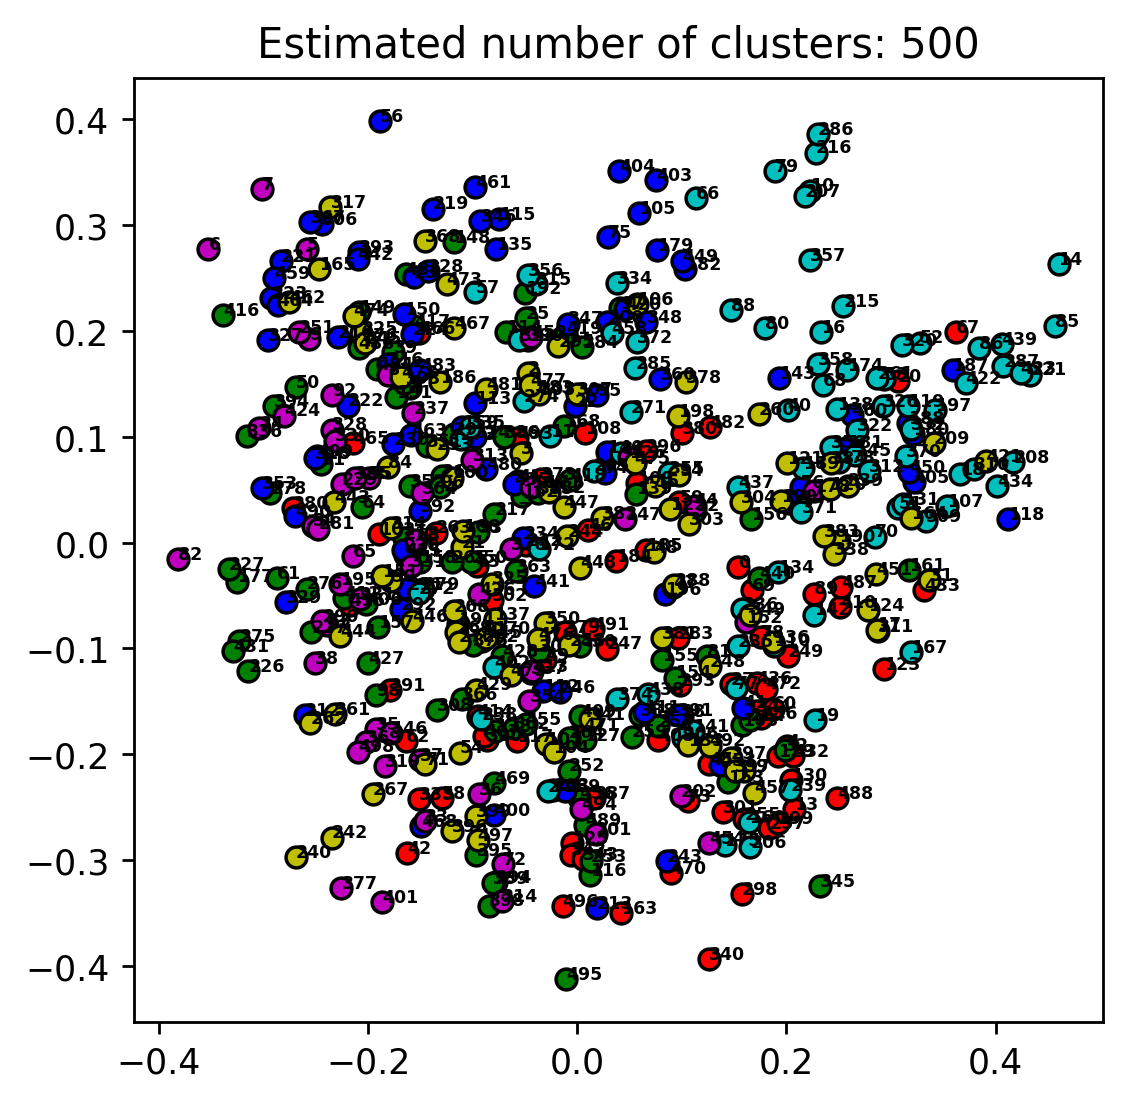

In [ ]:
rescale = 1


print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



plt.close('all')

#plt.figure().add_subplot(projection = '3d')


plt.figure(1)
plt.clf()
figure(figsize = (5,5), dpi=250)


for k, col, curr_factor in zip(trait_exemplars, color_key, factor_key):
   
    class_members = pd.DataFrame(final_df['Factor'] == curr_factor).to_numpy().flatten() # Exemplar Flag
    cluster_center = principalComponents[cluster_centers_indices[k]]
   
    plt.plot(cluster_center[0]*rescale, cluster_center[1]*rescale, 'o', markerfacecolor=col,
             markeredgecolor = 'k')
    
    plt.text(cluster_center[0]*rescale,cluster_center[1]*rescale, k, withdash=True, fontdict={"size":5, "weight":'bold'})

#    for x in principalComponents[class_members]:
#        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % len(cluster_centers_indices))
plt.savefig("Affinity Propogation.png",  pad_inches = .15)
#plt.show()



from google.colab import files
#files.download("Affinity Propogation.png") 


Estimated number of clusters: 500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

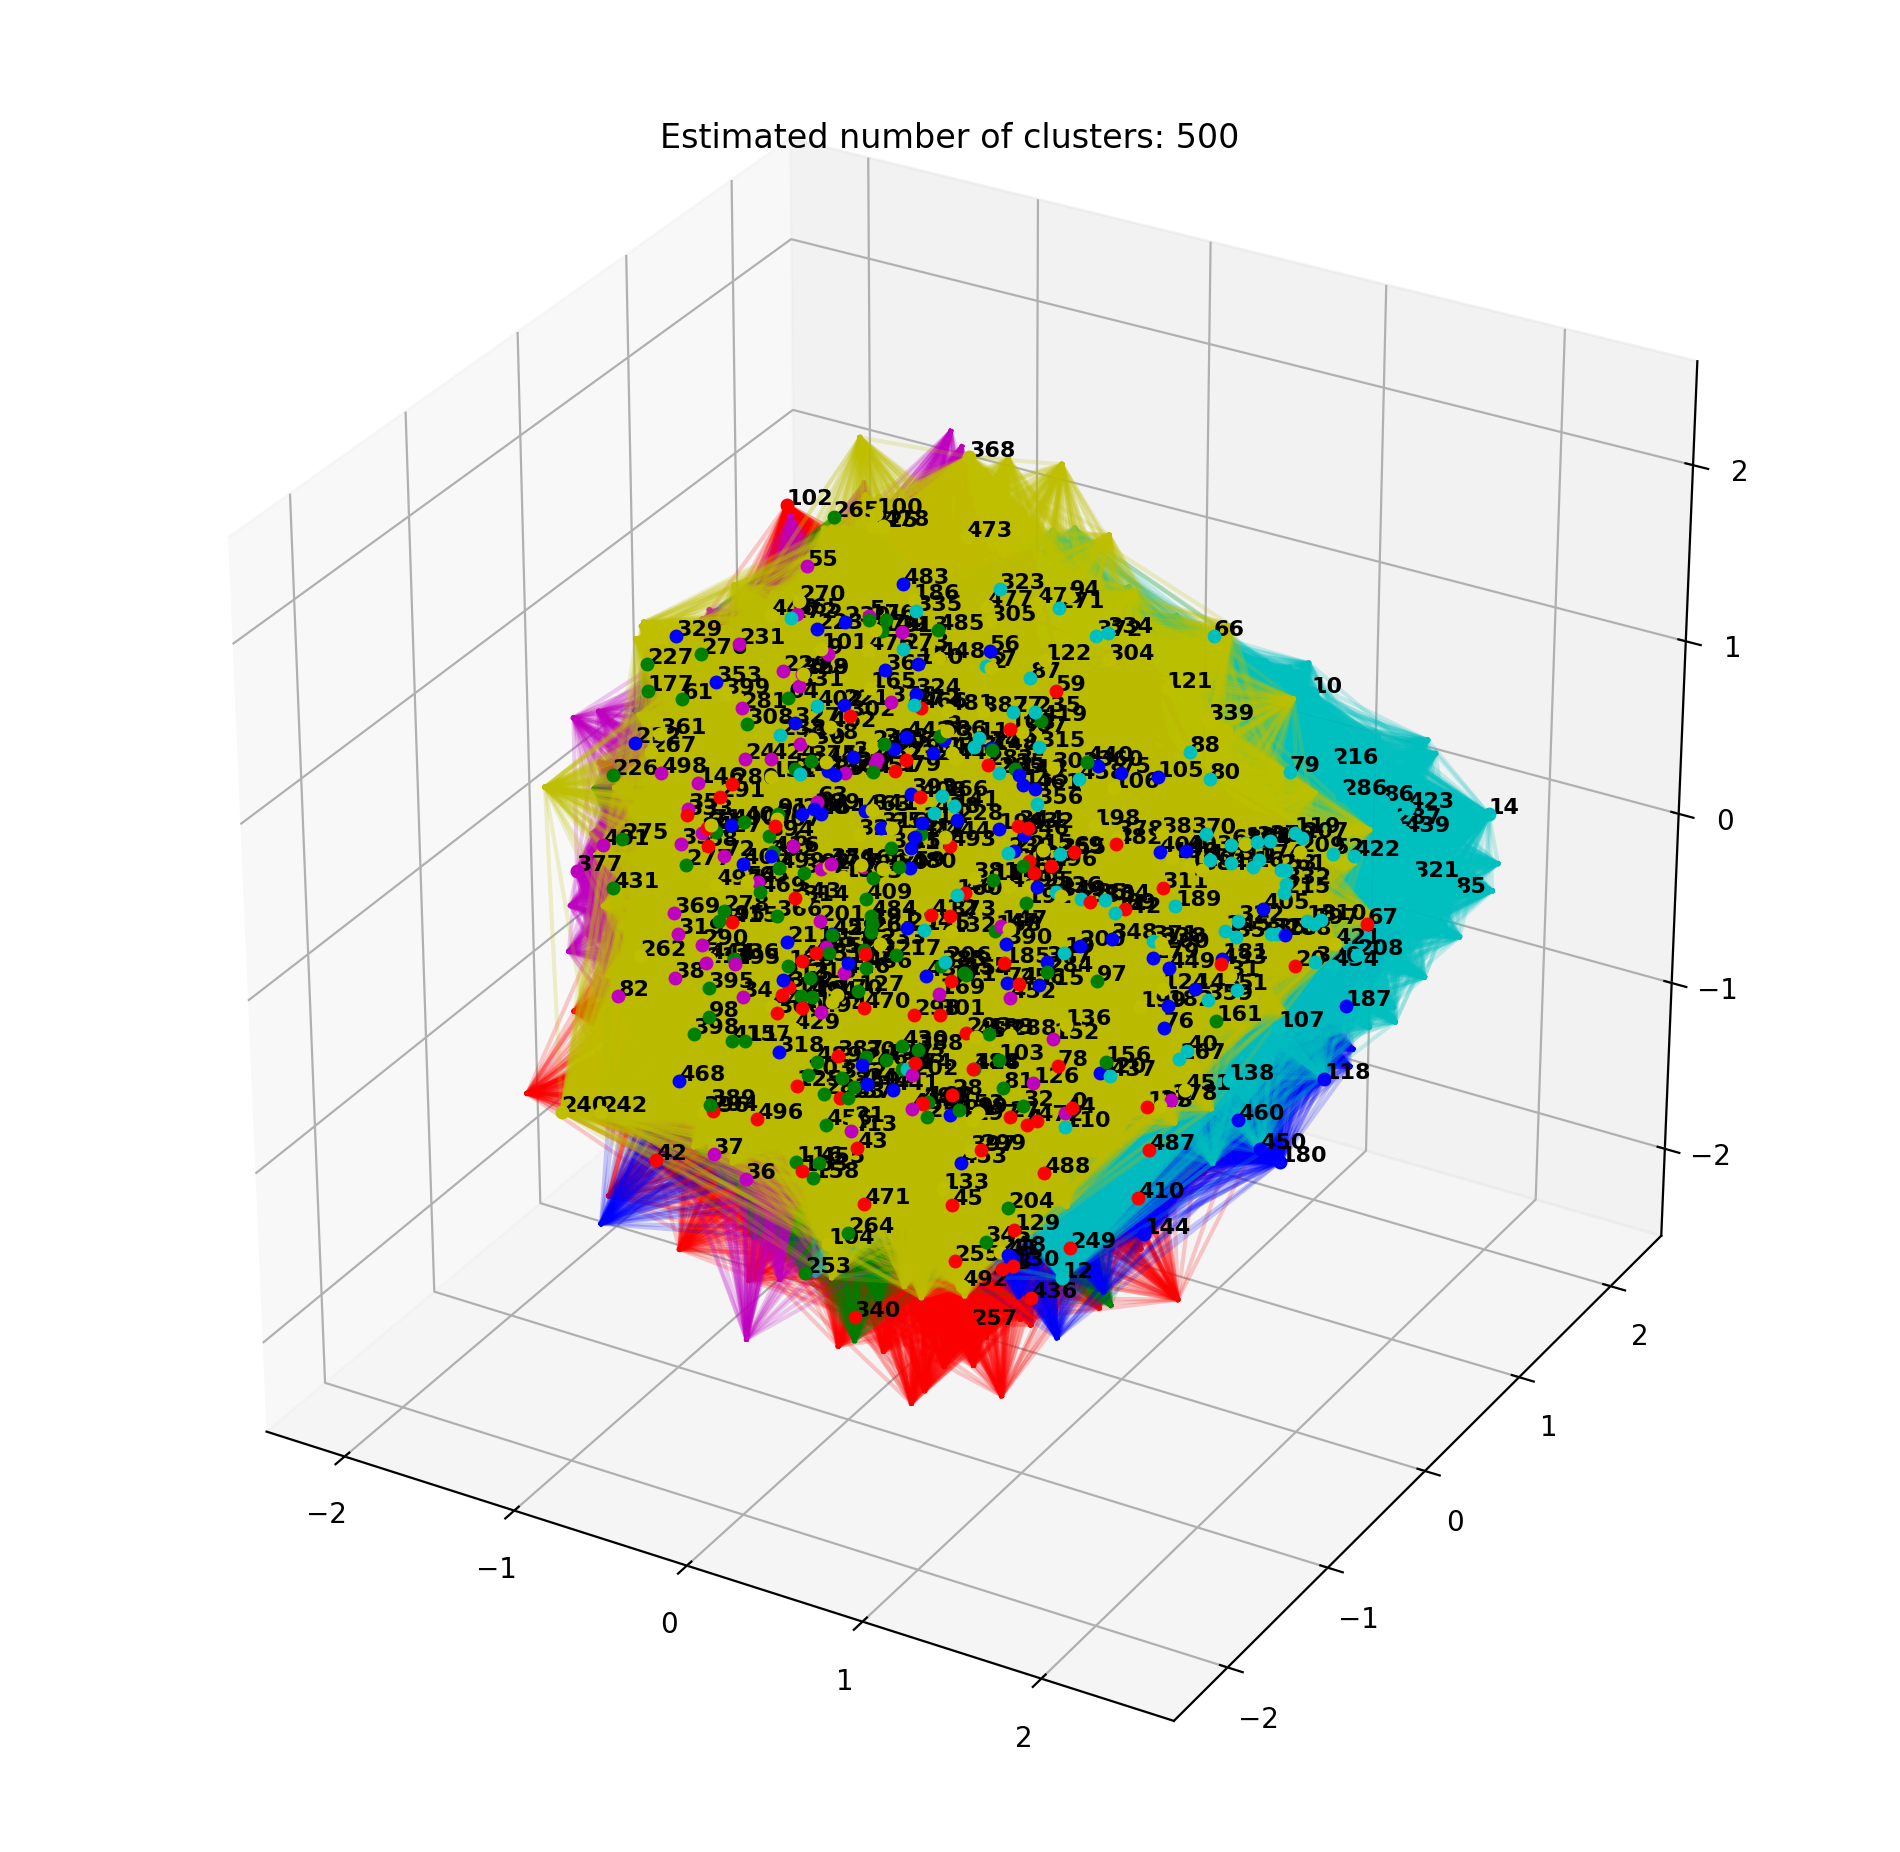

In [ ]:
rescale = 5


print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',  alpha = .4)

fig.set_size_inches(w=12,h=12)
fig.set_dpi(200)

#plt.figure(1)
#plt.clf()
#figure(figsize = (5,5), dpi=250)


for k, col, curr_factor in zip(trait_exemplars, color_key, factor_key):
   
    class_members = pd.DataFrame(final_df['Factor'] == curr_factor).to_numpy().flatten() # Exemplar Flag
    cluster_center = principalComponents[cluster_centers_indices[k]]
   
    ax.scatter(xs = cluster_center[0]*rescale, ys = cluster_center[1]*rescale, zs = cluster_center[2]*rescale, marker='o', c=col, s =16,  depthshade=True)
    
    ax.text3D(cluster_center[0]*rescale,cluster_center[1]*rescale, cluster_center[2]*rescale, k, withdash=True, fontdict={"size":8, "weight":'bold'})

    for x in principalComponents[class_members]:
        ax.plot3D([cluster_center[0]*rescale, x[0]*rescale], [cluster_center[1]*rescale, x[1]*rescale],
                  [cluster_center[2]*rescale, x[2]*rescale], col, alpha = .2)

plt.title('Estimated number of clusters: %d' % len(cluster_centers_indices))
plt.savefig("Affinity Propogation.png",  pad_inches = .15)
#plt.show()



from google.colab import files
files.download("Affinity Propogation.png") 
